# Creating HR data visualizations using Matplotlib and Seaborn

In [1]:
# data analysis libraries
import numpy as np
import pandas as pd
import scipy

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load the input file as dataframe
dei_data = pd.read_csv(filepath_or_buffer='records.csv')
dei_data.sample(n=5)

,ee#,employee_name,start_date,term_date,department,province,level,age,gender,ethnicity
3367,4368,Mr. Drew Smith,2023-02-27,2024-03-09,Sales,Prince Edward Island,Individual contributor,50,female,caucasian
4449,5450,Sergio Hurley,2019-10-12,2020-06-22,Legal,Ontario,Individual contributor,24,male,asian
2207,3208,Adam Crosby,1984-02-02,2019-07-08,Customer Service,Northwest Territories,Individual contributor,48,female,caucasian
4747,5748,Courtney Mckinney,2003-01-27,2006-01-05,HR,Newfoundland and Labrador,Individual contributor,46,female,caucasian
1221,2222,Alfred Brown,2018-05-30,2020-06-21,Customer Service,Quebec,Individual contributor,49,female,caucasian


In [3]:
# categorical data profiling with formatted outputs
def category_profiling(df, columns):
    print(df.nunique())
    print("---")
    for col in columns:
        percentages = df[col].value_counts(normalize=True).mul(100).round(1).astype(str)+'%'
        print(percentages)
        print("---")

columns = ['department', 'province', 'level', 'gender', 'ethnicity']

category_profiling(dei_data, columns)

ee#              4999
employee_name    4999
start_date       4453
term_date        3994
department          8
province           13
level               1
age                49
gender              2
ethnicity           2
dtype: int64
---
department
Finance               13.4%
Sales                 13.1%
Project Management    12.9%
HR                    12.9%
Legal                 12.3%
Customer Service      12.3%
Marketing             11.7%
IT                    11.4%
Name: proportion, dtype: object
---
province
Prince Edward Island         8.3%
Ontario                      8.2%
Quebec                       8.1%
Alberta                      8.0%
Manitoba                     8.0%
New Brunswick                7.8%
Nunavut                      7.6%
Northwest Territories        7.6%
British Columbia             7.6%
Newfoundland and Labrador    7.3%
Saskatchewan                 7.3%
Yukon Territory              7.2%
Nova Scotia                  6.9%
Name: proportion, dtype: object
---
level

## Analysis of age

In [4]:
# simple data profiling on the age column
print(f"Age: min= {dei_data['age'].min()}")
print(f"Age: max= {dei_data['age'].max()}")
print(f"Age: avg= {dei_data['age'].mean().round(0)}")
print(f"Age: stdev= {dei_data['age'].std()}")
print(f"Age: 1st quart= {np.percentile(a= dei_data['age'], q= 25)}")
print(f"Age: 2nd quart= {np.percentile(a= dei_data['age'], q= 50)}")
print(f"Age: 3rd quart= {np.percentile(a= dei_data['age'], q= 75)}")

# advanced statistical measures
from scipy.stats import skew
print(f"Age: skew= {skew(dei_data['age'], axis=0, bias=True)}")

from scipy.stats import kurtosis
print(f"Age: kurtosis= {kurtosis(dei_data['age'], axis=0, fisher=True, bias=True)}")

Age: min= 22
Age: max= 70
Age: avg= 46.0
Age: stdev= 14.2659333010645
Age: 1st quart= 34.0
Age: 2nd quart= 46.0
Age: 3rd quart= 58.0
Age: skew= 0.0115941326647231
Age: kurtosis= -1.2170471514714758


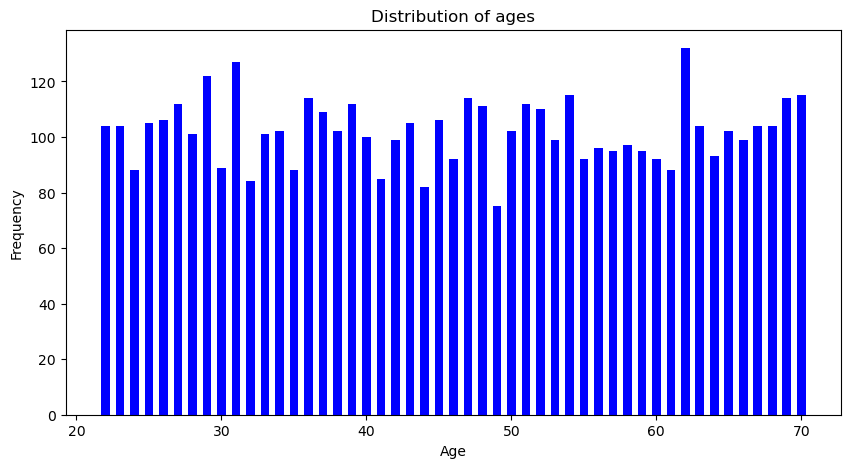

In [5]:
# distribution bar graph of ages
age_graph_data = dei_data['age'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(age_graph_data.index, age_graph_data.values, 
        color= 'blue', width= 0.6)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of ages')
plt.show()

In [6]:
# convert Age to numeric for preparation
dei_data['age'] = pd.to_numeric(dei_data['age'])

# creating age bins (e.g., 22-30, 31-40, 41-50, 51-60, 61-70)
bins= [22, 31, 41, 51, 61, 71]
labels= ['22-30', '31-40', '41-50', '51-60', '61-70']
dei_data['AgeGroup']= pd.cut(x= dei_data['age'], 
                             bins= bins,
                             labels= labels,
                             right= False)

# count of individuals per age group by gender
df_agg= dei_data.groupby(['AgeGroup', 'gender']).size().unstack(
    fill_value=0)
df_agg= df_agg.reset_index()
df_agg

gender,AgeGroup,female,male
0,22-30,309,622
1,31-40,348,691
2,41-50,337,634
3,51-60,317,686
4,61-70,316,739


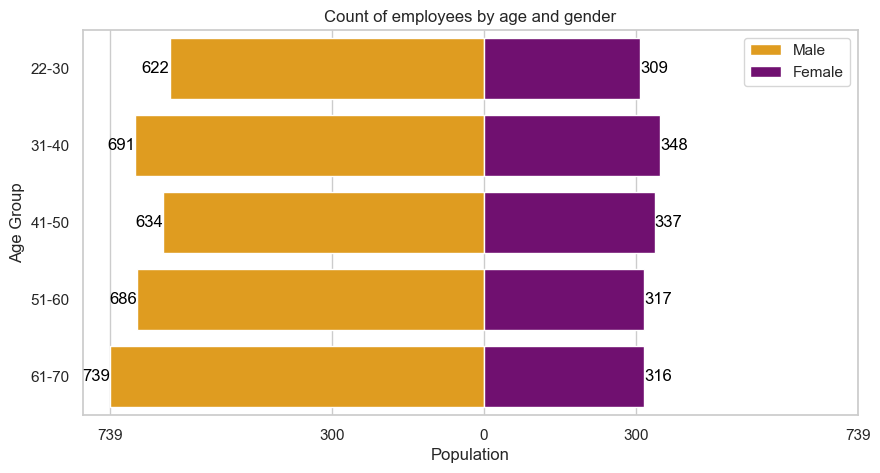

In [7]:
# distribution pyramid graph of ages
# setting up the figure and axes
plt.figure(figsize=(10,5))
sns.set(style="whitegrid")

# setting up the male population (in negative for left side)
sns.barplot(data= df_agg,
            x= -df_agg['male'],
            y= df_agg['AgeGroup'],
            color= 'orange',
            label= 'Male')

# setting up the female population
sns.barplot(data= df_agg,
            x= df_agg['female'],
            y= df_agg['AgeGroup'],
            color= 'purple',
            label= 'Female')

# Add data labels for male population
for index, value in enumerate(df_agg['male']):
    plt.text(-value, index, f'{value}', color='black', 
             ha='right', va='center')

# Add data labels for female population
for index, value in enumerate(df_agg['female']):
    plt.text(value, index, f'{value}', color='black', 
             ha='left', va='center')

# customizing the axes
plt.xlabel('Population')
plt.ylabel('Age Group')
plt.title('Count of employees by age and gender')
plt.legend()

# improving readability of x-axis labels
max_population = max(df_agg['male'].max(), df_agg['female'].max())
plt.xticks(ticks=[-max_population, -300, 
                  0, 300, max_population], 
           labels=[f'{max_population}', f'{300}', 
                   '0', f'{300}', f'{max_population}'])

# displaying the graph
plt.show()

## Tenure

In [8]:
# ensuring that start and term dates are date type
dei_data['start_date'] = pd.to_datetime(dei_data['start_date'])
dei_data['term_date'] = pd.to_datetime(dei_data['term_date'])

# calculating tenure
dei_data['tenure'] = ((dei_data['term_date'] - dei_data['start_date']).dt.days
                       / 365.25).round(1)


In [9]:
# simple data profiling on the tenure column
print(f"Tenure: min= {dei_data['tenure'].min()}")
print(f"Tenure: max= {dei_data['tenure'].max()}")
print(f"Tenure: avg= {dei_data['tenure'].mean().round(0)}")
print(f"Tenure: stdev= {dei_data['tenure'].std()}")
print(f"Tenure: 1st quart= {np.percentile(a= dei_data['tenure'], q= 25)}")
print(f"Tenure: 2nd quart= {np.percentile(a= dei_data['tenure'], q= 50)}")
print(f"Tenure: 3rd quart= {np.percentile(a= dei_data['tenure'], q= 75)}")

Tenure: min= 0.0
Tenure: max= 53.4
Tenure: avg= 14.0
Tenure: stdev= 12.057963992259351
Tenure: 1st quart= 3.6
Tenure: 2nd quart= 10.3
Tenure: 3rd quart= 21.2


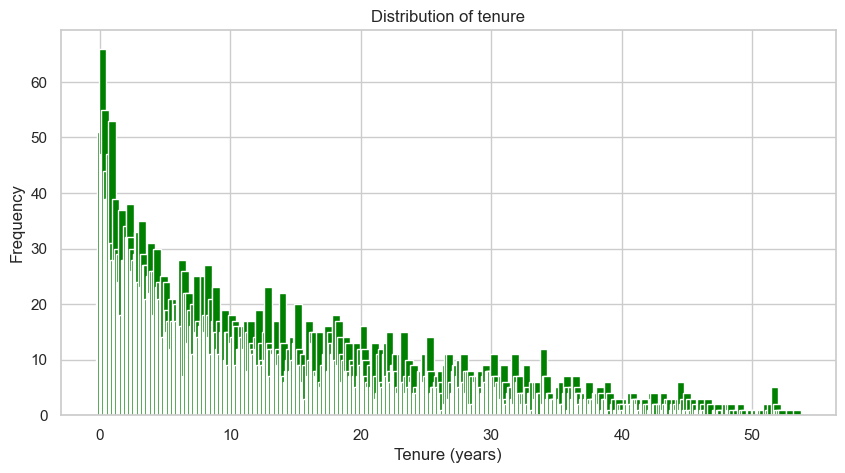

In [10]:
# distribution bar graph of tenure
tenure_graph_data = dei_data['tenure'].value_counts().sort_index()

plt.figure(figsize= (10,5))
plt.bar(tenure_graph_data.index, tenure_graph_data.values,
        color= 'green', width= 0.6)
plt.xlabel('Tenure (years)')
plt.ylabel('Frequency')
plt.title('Distribution of tenure')
plt.show()

In [11]:
# creating tenure bins (e.g., < 1 year, 1-3, 3-5)
tenure_bins= [0, 1.1, 3.1, 5.1, 10.1, 15.1, 30.1, 54]
tenure_labels= ['< 1 year', '1-3 years', '3-5 years', '5-10 years',
                '10-15 years', '15-30 years', '30+ years']
dei_data['TenureGroup']= pd.cut(x= dei_data['tenure'],
                                 bins= tenure_bins,
                                 labels= tenure_labels,
                                 right= False)

# count of individuals per tenure group by gender
tenure_agg= dei_data.groupby(['TenureGroup', 'gender']).size().unstack(
    fill_value=0)
tenure_agg= tenure_agg.reset_index()
tenure_agg

gender,TenureGroup,female,male
0,< 1 year,170,325
1,1-3 years,194,410
2,3-5 years,152,343
3,5-10 years,288,586
4,10-15 years,219,417
5,15-30 years,419,867
6,30+ years,185,424


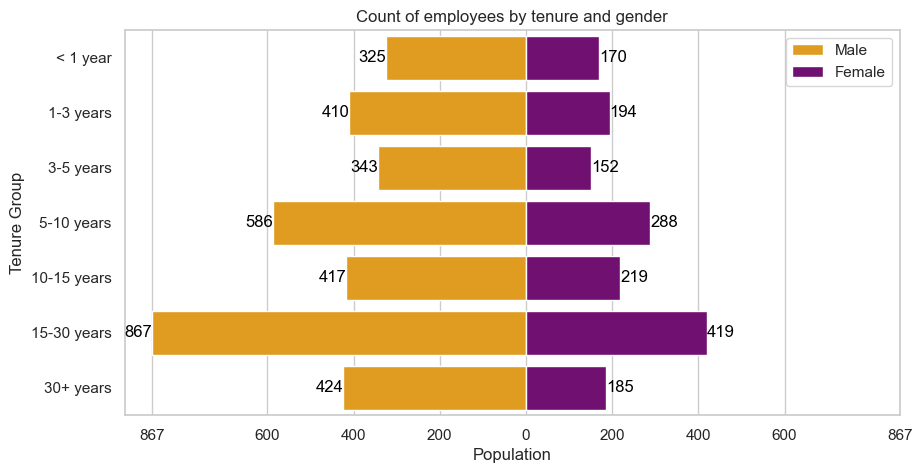

In [12]:
# distribution pyramid of tenure
# setting up the figure and axes
plt.figure(figsize=(10,5))
sns.set(style="whitegrid")

# setting up the male population (in negative for left side)
sns.barplot(data= tenure_agg,
            x= -tenure_agg['male'],
            y= tenure_agg['TenureGroup'],
            color= 'orange',
            label= 'Male')

# setting up the female population
sns.barplot(data= tenure_agg,
            x= tenure_agg['female'],
            y= tenure_agg['TenureGroup'],
            color= 'purple',
            label= 'Female')

# Add data labels for male population
for index, value in enumerate(tenure_agg['male']):
    plt.text(-value, index, f'{value}', color='black', 
             ha='right', va='center')

# Add data labels for female population
for index, value in enumerate(tenure_agg['female']):
    plt.text(value, index, f'{value}', color='black', 
             ha='left', va='center')

# customizing the axes
plt.xlabel('Population')
plt.ylabel('Tenure Group')
plt.title('Count of employees by tenure and gender')
plt.legend()

# improving readability of x-axis labels
max_population = max(tenure_agg['male'].max(), tenure_agg['female'].max())
plt.xticks(ticks=[-max_population, -600, -400, -200, 
                  0, 200, 400, 600, max_population], 
           labels=[f'{max_population}', f'{600}', f'{400}', f'{200}',
                   '0', f'{200}',f'{400}',f'{600}', f'{max_population}'])

# displaying the graph
plt.show()

## Hiring and terminations

In [13]:
# creating new columns with hiring & term years
dei_data['TermYear'] = dei_data['term_date'].dt.year
dei_data['StartYear'] = dei_data['start_date'].dt.year

In [14]:
# creating counts of new hires per year
hiring_agg= dei_data.groupby(['StartYear']).size()
hiring_agg= hiring_agg.reset_index()

# ensuring columns have proper names
hiring_agg.rename(columns={"StartYear":"Year", 
                           0:"Hire"},
                 inplace=True)

print(hiring_agg.columns)
hiring_agg.sample(n=5)

Index(['Year', 'Hire'], dtype='object')


,Year,Hire
54,2024,47
16,1986,86
18,1988,103
5,1975,73
40,2010,79


In [15]:
# creating counts of terminations per year
terms_agg= dei_data.groupby(['TermYear']).size()
terms_agg= terms_agg.reset_index()

# ensuring columns have proper names
terms_agg.rename(columns={"TermYear":"Year",
                          0:"Term"},
                 inplace=True)

print(terms_agg.columns)
terms_agg.sample(n=5)

Index(['Year', 'Term'], dtype='object')


,Year,Term
49,2019,234
35,2005,104
30,2000,96
40,2010,124
41,2011,130


In [16]:
# combining hires and departures
ee_movements= pd.merge(hiring_agg, terms_agg,
                       on='Year', how='outer')
ee_movements.sample(n=5)

,Year,Hire,Term
14,1984,108,23
12,1982,104,21
48,2018,74,191
20,1990,89,36
5,1975,73,12


In [17]:
# reshaping to fit graph format
ee_movements_graph= pd.melt(ee_movements,
                            id_vars= ['Year'],
                            value_vars= ['Hire','Term'],
                            var_name= 'Event',
                            value_name= 'Count')

ee_movements_graph.sample(n=5)

,Year,Event,Count
69,1984,Term,23
56,1971,Term,3
86,2001,Term,85
20,1990,Hire,89
73,1988,Term,41


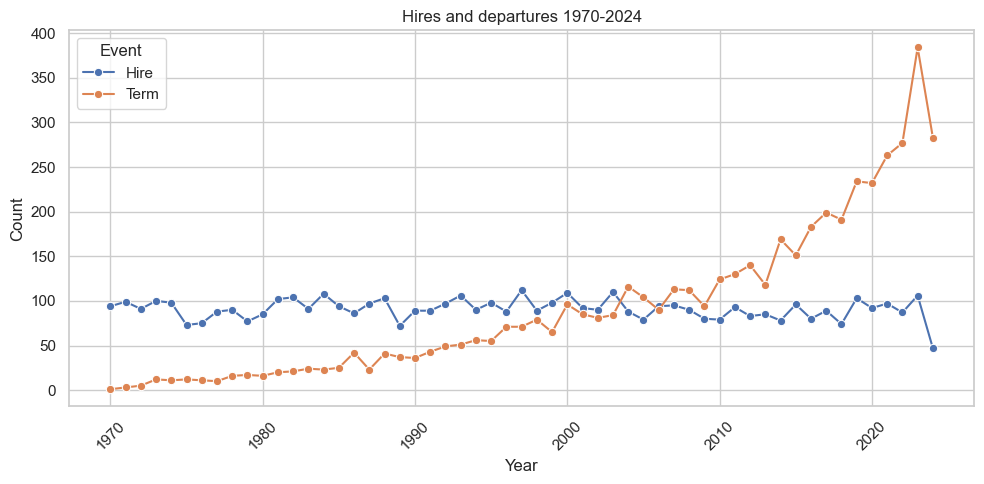

In [18]:
# setting the graph
plt.figure(figsize=(10,5))
sns.set(style= 'whitegrid')
sns.lineplot(data= ee_movements_graph,
             x= 'Year',
             y= 'Count',
             hue= 'Event',
             marker= 'o')

# customizing the plot
plt.title('Hires and departures 1970-2024')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Event')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## Geographical locations

The geographical shapefile required to display geographical data was downloaded from the Open Government Portal.

Reference: Boundary Files, 2016 Census. Statistics Canada Catalogue no. 92-160-X.
Available [here](https://open.canada.ca/data/en/dataset/a883eb14-0c0e-45c4-b8c4-b54c4a819edb).

In [19]:
# loading the shapefile into a variable
canada= gpd.read_file('lpr_000b16a_e/lpr_000b16a_e.shp')
print(canada.columns)
canada.sample(n=5)

Index(['PRUID', 'PRNAME', 'PRENAME', 'PRFNAME', 'PREABBR', 'PRFABBR',
       'geometry'],
      dtype='object')


,PRUID,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR,geometry
12,62,Nunavut,Nunavut,Nunavut,Nvt.,Nt,"MULTIPOLYGON (((6105932.626 3935743.411, 61062..."
4,24,Quebec / Québec,Quebec,Québec,Que.,Qc,"MULTIPOLYGON (((8399709.494 2261445.703, 84005..."
3,13,New Brunswick / Nouveau-Brunswick,New Brunswick,Nouveau-Brunswick,N.B.,N.-B.,"MULTIPOLYGON (((8176224.537 1722553.460, 81762..."
10,60,Yukon,Yukon,Yukon,Y.T.,Yn,"MULTIPOLYGON (((4593284.320 4180399.606, 45933..."
8,48,Alberta,Alberta,Alberta,Alta.,Alb.,"POLYGON ((5228304.177 2767597.891, 5228098.463..."


In [20]:
# creating the count of employees per province
province_agg= dei_data.groupby(['province']).size()
province_agg= province_agg.reset_index()
province_agg.rename(columns={0:'Count'},
                    inplace= True)
province_agg

,province,Count
0,Alberta,402
1,British Columbia,379
2,Manitoba,398
3,New Brunswick,390
4,Newfoundland and Labrador,367
5,Northwest Territories,380
6,Nova Scotia,347
7,Nunavut,382
8,Ontario,411
9,Prince Edward Island,413


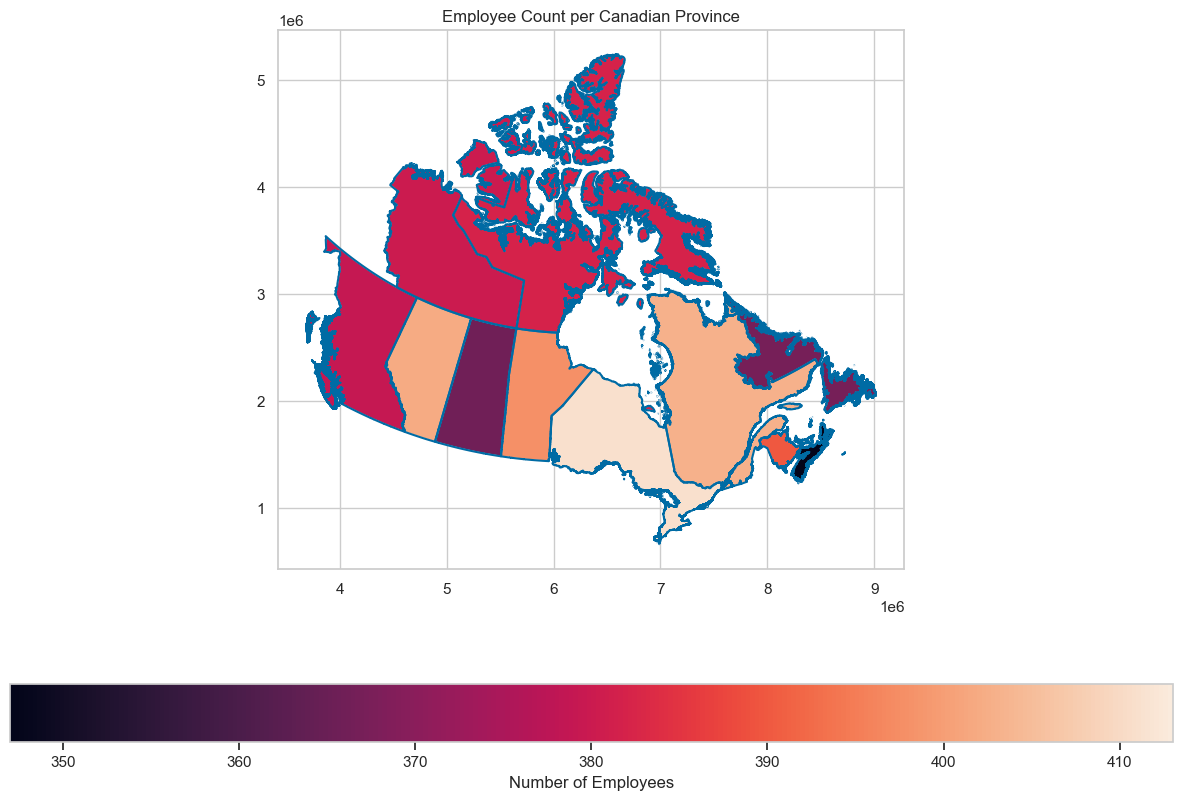

In [21]:
# merging employee data with geospatial data
canada= canada.merge(province_agg, 
                     left_on= 'PRENAME',
                     right_on= 'province')

# Plot the map
plt.style.use('tableau-colorblind10')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

canada.boundary.plot(ax=ax)
canada.plot(column='Count', ax=ax, legend=True,
            legend_kwds={'label': "Number of Employees",
                         'orientation': "horizontal"})

plt.title('Employee Count per Canadian Province')
plt.show()